In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')

In [2]:
%config Completer.use_jedi = False
%matplotlib inline

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Dataset preperation

In [10]:
dataset_dir = "data/train_data/openpose_mfcc_derivatives/"

input_x = np.array([]).reshape(0, 793 * 3)
input_y = np.array([]).reshape(0, 84)

for i in os.listdir(dataset_dir):
    d = np.load(os.path.join(dataset_dir, i))
    
    input_x = np.concatenate((input_x, d["x"]), axis=0)
    input_y = np.concatenate((input_y, d["y"]), axis=0)

indices = np.unique(np.concatenate((np.argwhere(input_y < -1)[:, 0], np.argwhere(input_y > 1)[:, 0])))

init_size = len(input_x)

input_x = np.delete(input_x, indices, axis=0)
input_y = np.delete(input_y, indices, axis=0)

# input_x = input_x[:, :793]

print(f"Out of {init_size} samples, {len(indices)} were removed.")

train_x, val_x, train_y, val_y = train_test_split(input_x, input_y, random_state=123, shuffle=True, test_size=0.2)

Out of 234356 samples, 24684 were removed.


In [23]:
def get_invidiuals_dataset(video_id):
    dataset = np.load(f"data/train_data/openpose_mfcc_derivatives/{video_id}.npz")

    input_x = dataset["x"]
    input_y = dataset["y"]

    indices = np.unique(np.concatenate((np.argwhere(input_y < -1)[:, 0], np.argwhere(input_y > 1)[:, 0])))

    input_x = np.delete(input_x, indices, axis=0)
    input_y = np.delete(input_y, indices, axis=0)

#     input_x = input_x[:, :793]

    print(f"Out of {len(dataset['x'])} samples, {len(indices)} were removed.")
    
    train_x, val_x, train_y, val_y = train_test_split(input_x, input_y, random_state=123, shuffle=True, test_size=0.5)
    
    return train_x, val_x, train_y, val_y
    

### NN model

In [15]:
def build_model():
    inputs = tf.keras.Input(shape=(793 * 3, ))

    x = Dense(2379, activation='tanh')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(1118 * 3, activation='tanh')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(84, activation="tanh")(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [16]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2379)]            0         
                                                                 
 dense_6 (Dense)             (None, 2379)              5662020   
                                                                 
 dropout_4 (Dropout)         (None, 2379)              0         
                                                                 
 dense_7 (Dense)             (None, 3354)              7982520   
                                                                 
 dropout_5 (Dropout)         (None, 3354)              0         
                                                                 
 dense_8 (Dense)             (None, 84)                281820    
                                                                 
Total params: 13,926,360
Trainable params: 13,926,360
Non-t

In [17]:
history = model.fit(
    train_x, train_y, 
    validation_data=(val_x, val_y), 
    shuffle=True, batch_size=128, epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)

2022-04-29 12:15:50.719860: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1596185292 exceeds 10% of free system memory.


Epoch 1/50
1311/1311 [==============================] - 7s 5ms/step - loss: 0.2769 - val_loss: 0.1198
Epoch 2/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.1553 - val_loss: 0.1030
Epoch 3/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.1168 - val_loss: 0.1002
Epoch 4/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.1029 - val_loss: 0.0960
Epoch 5/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0991 - val_loss: 0.0949
Epoch 6/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0980 - val_loss: 0.0971
Epoch 7/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0974 - val_loss: 0.0963
Epoch 8/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0971 - val_loss: 0.0964
Epoch 9/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0968 - val_loss: 0.0941
Epoch 10/50
1311/1311 [==============================] - 6s 4ms/step - loss: 0.096

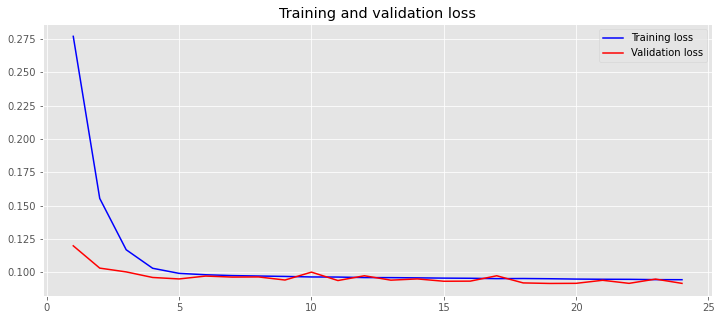

In [18]:
plot_history(history)

In [19]:
caption_files = glob.glob("data/captions/*.csv")

for caption_file in caption_files:
    
    video_id = caption_file.split("/")[-1].replace(".csv", "")
    text_feature_file = f"data/features/text/{video_id}.npy"

    captions = pd.read_csv(caption_file)
    
    output_folder = os.path.join("data/predictions", video_id)

    if not os.path.exists(output_folder): os.mkdir(output_folder)

    for i in range(len(captions)):
        t, d = captions.iloc[i, [0, 1]]

        audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"
        audio_feature_d1_file = f"data/features/audio/{video_id}/audio_feat_d1_{t}_{d}.npy"
        audio_feature_d2_file = f"data/features/audio/{video_id}/audio_feat_d2_{t}_{d}.npy"

        if os.path.exists(audio_feature_file):
#             audio_features = np.load(audio_feature_file)
#             audio_features = audio_features.reshape(audio_features.shape[0], -1)
            
            audio_features = np.load(audio_feature_file)
            audio_features_d1 = np.load(audio_feature_d1_file)
            audio_features_d2 = np.load(audio_feature_d2_file)
            
            x1 = audio_features.reshape(audio_features.shape[0], -1)
            x2 = audio_features_d1.reshape(audio_features_d1.shape[0], -1)
            x3 = audio_features_d2.reshape(audio_features_d2.shape[0], -1)

            xf = np.concatenate((x1, x2, x3), axis=1)
            
            predictions = model.predict(audio_features)
            
            output_file = f"data/predictions/{video_id}/handpose_{t}_{d}.npy"
            
            np.save(output_file, predictions)

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 2379), found shape=(None, 61, 13)


In [20]:
init_weights = model.get_weights()

In [24]:
train_x, val_x, train_y, val_y = get_invidiuals_dataset("4zLmWpMDY8Q")

Out of 3789 samples, 581 were removed.


In [25]:
history = model.fit(
    train_x, train_y, 
    validation_data=(val_x, val_y), 
    shuffle=True, batch_size=32, epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)

Epoch 1/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0819 - val_loss: 0.0847
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0810 - val_loss: 0.0865
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0828 - val_loss: 0.0898
Epoch 4/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0812 - val_loss: 0.0868
Epoch 5/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0797 - val_loss: 0.0882
Epoch 6/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0783 - val_loss: 0.0863


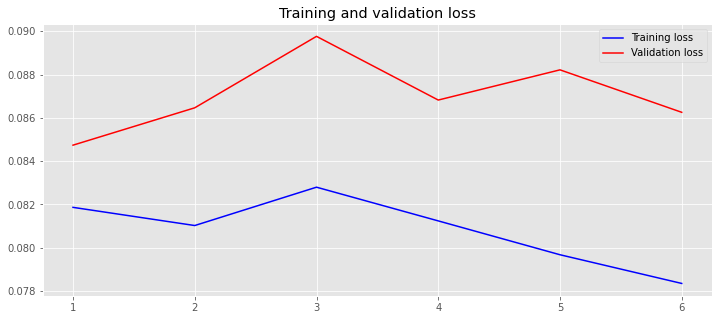

In [26]:
plot_history(history)

In [29]:
video_id = "4zLmWpMDY8Q"
text_feature_file = f"data/features/text/{video_id}.npy"

captions = pd.read_csv(f"data/captions/{video_id}.csv")

output_folder = os.path.join("data/predictions", video_id)

if not os.path.exists(output_folder): os.mkdir(output_folder)

for i in range(len(captions)):
    t, d = captions.iloc[i, [0, 1]]
    
    audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"
    audio_feature_d1_file = f"data/features/audio/{video_id}/audio_feat_d1_{t}_{d}.npy"
    audio_feature_d2_file = f"data/features/audio/{video_id}/audio_feat_d2_{t}_{d}.npy"

    if os.path.exists(audio_feature_file):
        audio_features = np.load(audio_feature_file)
        audio_features_d1 = np.load(audio_feature_d1_file)
        audio_features_d2 = np.load(audio_feature_d2_file)

        x1 = audio_features.reshape(audio_features.shape[0], -1)
        x2 = audio_features_d1.reshape(audio_features_d1.shape[0], -1)
        x3 = audio_features_d2.reshape(audio_features_d2.shape[0], -1)

        xf = np.concatenate((x1, x2, x3), axis=1)
        predictions = model.predict(xf)

        output_file = f"{output_folder}/handpose_{t}_{d}.npy"
        np.save(output_file, predictions)

#     audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"

#     if os.path.exists(audio_feature_file):
#         audio_features = np.load(audio_feature_file)
#         audio_features = audio_features.reshape(audio_features.shape[0], -1)

#         predictions = model.predict(audio_features)

#         output_file = f"{output_folder}/handpose_{t}_{d}.npy"

#         np.save(output_file, predictions)

In [30]:
!chown -R 1000:1000 data/predictions/*

### LSTM model

In [20]:
dataset_dir = "data/train_data/openpose"

input_x = np.array([]).reshape(0, 1561)
input_y = np.array([]).reshape(0, 84)

for i in os.listdir(dataset_dir):
    d = np.load(os.path.join(dataset_dir, i))
    
    input_x = np.concatenate((input_x, d["x"]), axis=0)
    input_y = np.concatenate((input_y, d["y"]), axis=0)

indices = np.unique(np.concatenate((np.argwhere(input_y < -1)[:, 0], np.argwhere(input_y > 1)[:, 0])))

init_size = len(input_x)

input_x = np.delete(input_x, indices, axis=0)
input_y = np.delete(input_y, indices, axis=0)

print(f"Out of {init_size} samples, {len(indices)} were removed.")

input_x_audio = input_x[:, :793]

input_x_audio = input_x_audio.reshape(input_x.shape[0], 61, 13)

input_x_text = input_x[:, 793:]

train_x_audio, val_x_audio, train_x_text, val_x_text, train_y, val_y = train_test_split(
    input_x_audio, input_x_text, input_y,
    random_state=123, shuffle=True, test_size=0.2
)

Out of 234356 samples, 24684 were removed.


In [25]:
def get_invidiuals_dataset(video_id):
    dataset = np.load(f"data/train_data/openpose/{video_id}.npz")

    input_x = dataset["x"]
    input_y = dataset["y"]

    indices = np.unique(np.concatenate((np.argwhere(input_y < -1)[:, 0], np.argwhere(input_y > 1)[:, 0])))

    init_size = len(input_x)

    input_x = np.delete(input_x, indices, axis=0)
    input_y = np.delete(input_y, indices, axis=0)

    print(f"Out of {init_size} samples, {len(indices)} were removed.")

    input_x_audio = input_x[:, :793]

    input_x_audio = input_x_audio.reshape(input_x.shape[0], 61, 13)

    input_x_text = input_x[:, 793:]

    train_x_audio, val_x_audio, train_x_text, val_x_text, train_y, val_y = train_test_split(
        input_x_audio, input_x_text, input_y,
        random_state=123, shuffle=True, test_size=0.2
    )
    
    return train_x_audio, val_x_audio, train_x_text, val_x_text, train_y, val_y

In [21]:
def build_model():
    audio_input = tf.keras.Input(shape=(61, 13))
    text_input = tf.keras.Input(shape=(768, ))

    x = LSTM(13)(audio_input)
    x = Dropout(0.3)(x)
    
    x = concatenate([x, text_input], axis=1)
    
    x = Dense(396, activation="tanh")(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(84, activation="tanh")(x)

    model = Model(inputs=[audio_input, text_input], outputs=outputs)
    
    return model

In [22]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 61, 13)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 13)           1404        ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 13)           0           ['lstm[0][0]']                   
                                                                                                  
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                            

In [23]:
history = model.fit(
    (train_x_audio, train_x_text), train_y, 
    validation_data=((val_x_audio, val_x_text), val_y), 
    shuffle=True, batch_size=128, epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50


2022-04-29 08:18:18.034174: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1311/1311 [==============================] - 14s 8ms/step - loss: 0.1150 - val_loss: 0.0934
Epoch 2/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0939 - val_loss: 0.0914
Epoch 3/50
1311/1311 [==============================] - 9s 7ms/step - loss: 0.0930 - val_loss: 0.0919
Epoch 4/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0924 - val_loss: 0.0911
Epoch 5/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0920 - val_loss: 0.0916
Epoch 6/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0917 - val_loss: 0.0909
Epoch 7/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0915 - val_loss: 0.0897
Epoch 8/50
1311/1311 [==============================] - 9s 6ms/step - loss: 0.0910 - val_loss: 0.0899
Epoch 9/50
1311/1311 [==============================] - 8s 6ms/step - loss: 0.0906 - val_loss: 0.0918
Epoch 10/50
1311/1311 [==============================] - 9s 7ms/step - loss: 0.0903 - val_lo

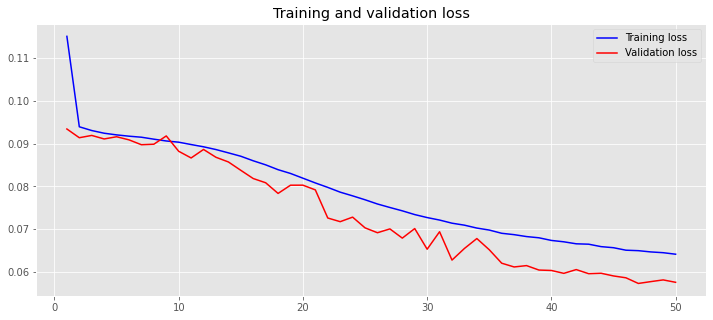

In [24]:
plot_history(history)

In [26]:
init_weights = model.get_weights()

In [27]:
train_x_audio, val_x_audio, train_x_text, val_x_text, train_y, val_y = get_invidiuals_dataset("4zLmWpMDY8Q")

Out of 3789 samples, 581 were removed.


In [28]:
history = model.fit(
    (train_x_audio, train_x_text), train_y, 
    validation_data=((val_x_audio, val_x_text), val_y), 
    shuffle=True, batch_size=128, epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0605 - val_loss: 0.0513
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0563 - val_loss: 0.0555
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0577 - val_loss: 0.0519
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0558 - val_loss: 0.0509
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0536 - val_loss: 0.0515
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0531 - val_loss: 0.0495
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0543 - val_loss: 0.0607
Epoch 8/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0573 - val_loss: 0.0513
Epoch 9/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0554 - val_loss: 0.0526
Epoch 10/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0523 - val_loss: 0.0517
Epoch 11/50
21/21 [

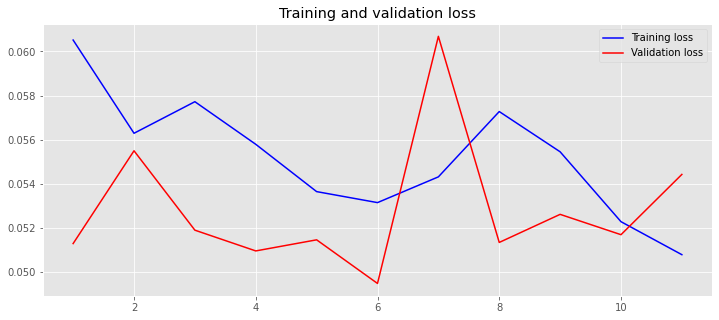

In [29]:
plot_history(history)

In [32]:
video_id = "4zLmWpMDY8Q"
text_feature_file = f"data/features/text/{video_id}.npy"

captions = pd.read_csv(f"data/captions/{video_id}.csv")

output_folder = os.path.join("data/predictions_lstm", video_id)

if not os.path.exists(output_folder): os.mkdir(output_folder)

for i in range(len(captions)):
    t, d = captions.iloc[i, [0, 1]]

    audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"
    text_features_all = np.load(f"data/features/text/{video_id}.npy")

    if os.path.exists(audio_feature_file):
        audio_features = np.load(audio_feature_file)
            
        text_features = text_features_all[i].reshape(1, -1).repeat(audio_features.shape[0], axis=0)

        predictions = model.predict((audio_features, text_features))

        output_file = f"{output_folder}/handpose_{t}_{d}.npy"

        np.save(output_file, predictions)

### Prediction

In [11]:
def build_model():
    audio_input = tf.keras.Input(shape=(61, 13))

    x = LSTM(13)(audio_input)
    x = Dropout(0.3)(x)
    
    outputs = Dense(84, activation="tanh")(x)

    model = Model(inputs=audio_input, outputs=outputs)
    
    return model

In [15]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 61, 13)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 13)                1404      
                                                                 
 dropout_5 (Dropout)         (None, 13)                0         
                                                                 
 dense_5 (Dense)             (None, 84)                1176      
                                                                 
Total params: 2,580
Trainable params: 2,580
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(
    train_x_audio, train_y, 
    validation_data=(val_x_audio, val_y), 
    shuffle=True, batch_size=128, epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
489/489 [==============================] - 4s 6ms/step - loss: 0.1039 - val_loss: 0.0895
Epoch 2/50
489/489 [==============================] - 3s 6ms/step - loss: 0.0855 - val_loss: 0.0812
Epoch 3/50
489/489 [==============================] - 5s 10ms/step - loss: 0.0789 - val_loss: 0.0767
Epoch 4/50
489/489 [==============================] - 7s 14ms/step - loss: 0.0754 - val_loss: 0.0742
Epoch 5/50
489/489 [==============================] - 7s 15ms/step - loss: 0.0734 - val_loss: 0.0728
Epoch 6/50
489/489 [==============================] - 7s 15ms/step - loss: 0.0723 - val_loss: 0.0720
Epoch 7/50
489/489 [==============================] - 7s 14ms/step - loss: 0.0717 - val_loss: 0.0716
Epoch 8/50
489/489 [==============================] - 7s 15ms/step - loss: 0.0714 - val_loss: 0.0714
Epoch 9/50
489/489 [==============================] - 3s 5ms/step - loss: 0.0713 - val_loss: 0.0713
Epoch 10/50
489/489 [==============================] - 2s 4ms/step - loss: 0.0712 - val_loss: 

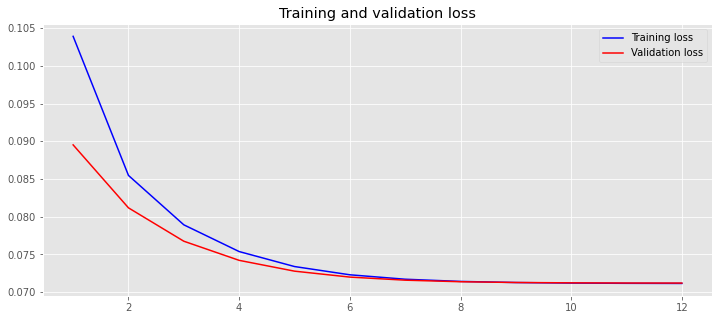

In [17]:
plot_history(history)

In [18]:
caption_files = glob.glob("data/captions/*.csv")

for caption_file in caption_files:
    
    video_id = caption_file.split("/")[-1].replace(".csv", "")

    captions = pd.read_csv(caption_file)
    
    output_folder = os.path.join("data/predictions_lstm", video_id)

    if not os.path.exists(output_folder): os.mkdir(output_folder)

    for i in range(len(captions)):
        t, d = captions.iloc[i, [0, 1]]

        audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"

        if os.path.exists(audio_feature_file):
            audio_features = np.load(audio_feature_file)
            
            predictions = model.predict(audio_features)
            
            output_file = f"{output_folder}/handpose_{t}_{d}.npy"
            
            np.save(output_file, predictions)

In [30]:
!chown -R 1000:1000 data/predictions_lstm//*